In [1]:
import pandas
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import numpy as np
import torch
from torch import nn
from sklearn.metrics import f1_score

In [2]:
import sys
print(sys.executable)

/usr/bin/python3


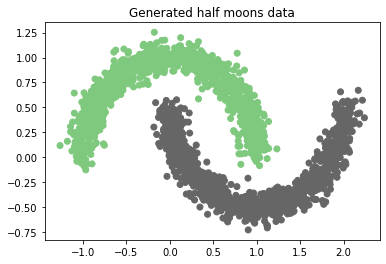

In [3]:
n_samples = 2000  # number of samples to generate
noise = 0.08 # noise to add to sample locations
x, y = datasets.make_moons(n_samples=n_samples, noise=noise)
plt.scatter(*x.T, c=y, cmap=plt.cm.Accent)
plt.title("Generated half moons data");

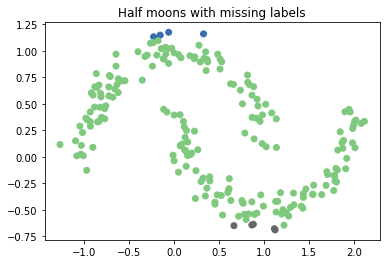

In [5]:
unlabeled_frac = 0.995  # fraction of data to drop labels
y_ssml = y.copy()
zero_indexs = np.where(y == 0)[0]
one_indexs = np.where(y == 1)[0]
y_ssml[:] = -1
unlabeled = np.random.choice(np.where(x[:,1] >= 1.1 )[0], size=int((1-unlabeled_frac) * len(zero_indexs)), replace=False)
y_ssml[unlabeled] = 0  # set missing labels to -1
unlabeled = np.random.choice(np.where(x[:,1] <= -0.61)[0], size=int((1-unlabeled_frac) * len(one_indexs)), replace=False)
y_ssml[unlabeled] = 1  # set missing labels to -1


# unlabeled_frac = 0.99  # fraction of data to drop labels
# y_ssml = y.copy()
# zero_indexs = np.where(y == 0)[0]
# one_indexs = np.where(y == 1)[0]
# unlabeled = np.random.choice(zero_indexs, size=int((unlabeled_frac) * len(zero_indexs)), replace=False)
# y_ssml[unlabeled] = -1  # set missing labels to -1
# unlabeled = np.random.choice(one_indexs, size=int((unlabeled_frac) * len(one_indexs)), replace=False)
# y_ssml[unlabeled] = -1  # set missing labels to -1


number_of_dataset = 100
datax = []
datay = []
for i, label in enumerate(y_ssml):
  if label == -1 and np.random.random() <= (2 * number_of_dataset/n_samples):
    datax.append(x[i])
    datay.append(label)
  elif label != -1:
    datax.append(x[i])
    datay.append(label)
datax = np.array(datax)
datay = np.array(datay)

plt.scatter(*datax.T, c=datay, cmap=plt.cm.Accent)
plt.title("Half moons with missing labels");

10


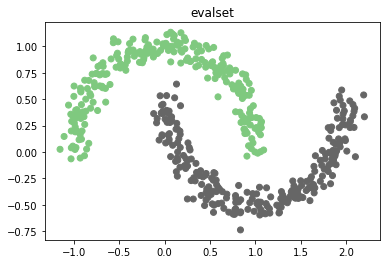

In [6]:
index = (datay == -1)
unlabeldX = datax[index]
labaled = datax[~index]
Y = datay[~index]
xval, yval = datasets.make_moons(n_samples= int(n_samples/4), noise=noise)
# evalindex = np.where((xval[:,1] >= -0.5) & (xval[:,1] < 1))[0]
# xval = xval[evalindex]
# yval = yval[evalindex]
print(len(Y))
plt.scatter(*xval.T, c=yval, cmap=plt.cm.Accent)
plt.title("evalset");

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
        torch.nn.Linear(2, 20),
        torch.nn.ReLU(),
        nn.BatchNorm1d(20),
        torch.nn.Linear(20, 20),
        torch.nn.ReLU(),
        nn.BatchNorm1d(20),
        torch.nn.Linear(20, 1),
        torch.nn.Sigmoid())
    def forward(self,x):
        return self.model(x)

def update_teacher(teacher, student, alpha = 0.2):
    for tparam, param in zip(teacher.parameters(), student.parameters()):
            tparam.data[:] = alpha * tparam.data[:] + (1 - alpha) * param[:].data[:]
    return teacher
def print_teacher(teacher):
      for tparam in teacher.parameters():
        print(tparam)
        break

def batch_sampler(X,XL,y, bl = 128, bu = 128):
    uindex1 = np.random.choice(range(len(X)), size= min(bu,len(X)), replace=False)
    uindex2 = np.random.choice(range(len(X)), size= min(bu,len(X)), replace=False)
    lindex = np.random.choice(range(len(XL)), size= min(bl,len(XL)), replace=False)
    return torch.tensor(X[uindex1], dtype = torch.float),torch.tensor(X[uindex2],dtype = torch.float),torch.tensor(XL[lindex],dtype = torch.float),torch.tensor(y[lindex],dtype = torch.float)

def batch_loader(X,XL,y, bl = 512):
    uindex1 = np.random.choice(range(len(X)), size= len(X), replace=False)
    lindex = np.random.choice(range(len(XL)), size= len(XL), replace=False)
    X = X[uindex1]
    XL = XL[lindex]
    y = y[lindex]
    for i in range(int(len(XL)/bl) + 1):
        xh = XL[i*bl:min(len(XL),(i+1)*bl)]
        yh = y[i*bl:min(len(XL),(i+1)*bl)]
        yield torch.tensor(xh, dtype = torch.float) , torch.tensor(yh,dtype = torch.float)

pytorch_total_params = sum(p.numel() for p in Classifier().parameters())
print(pytorch_total_params)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

581
cuda


In [29]:
update_rate = 8e-2
w = lambda t : 100/(1+(100) * np.exp(-t))
T = 1000
mix = lambda l,x1,x2 : l * x1 + (1-l) * x2
alpha = 10

In [30]:
# train 
import copy
student_model = Classifier().to(device)
teacher_model = Classifier().to(device)
optimizer = torch.optim.SGD(student_model.parameters(), lr=1e-3, momentum=0.9)

best_model = Classifier()
best_val = 0
for t in range(T):
    optimizer.zero_grad()
    student_model.train()
    teacher_model.eval()
    X1,X2,XL,yl = batch_sampler(unlabeldX, labaled, Y,4 ,2)
    X1,X2,XL,yl = X1.to(device), X2.to(device), XL.to(device), yl.to(device)
    pre = student_model(XL).squeeze()
    #print(pre)
    losssup = nn.BCELoss()(pre,yl)
    
    #with torch.no_grad():
    y1hat = teacher_model(X1)
    y2hat = teacher_model(X2)
        
    l = np.random.beta(alpha,alpha)
    X = mix(l, X1,X2)
    yhat = mix(l, y1hat, y2hat)

    lossC = nn.MSELoss()(student_model(X),yhat)
    loss = losssup + w(t)* lossC
    loss.backward()
    teacher_model = update_teacher(teacher_model, student_model,update_rate)
    optimizer.step()
    with torch.no_grad():
        student_model.eval()
        predict = student_model(torch.tensor(xval, dtype = torch.float).to(device)).squeeze() >= 0.5
        valacc = f1_score(yval, predict.squeeze().cpu().numpy())
        if valacc > best_val:
            best_val = valacc
            best_model = copy.deepcopy(student_model)
            print(t,best_val)
            #print_teacher(teacher_model)
print(best_val)

0 0.36065573770491804
1 0.4709480122324159
2 0.5549132947976879
3 0.6111111111111112
21 0.6161616161616161
22 0.654292343387471
23 0.6915113871635611
222 0.7136690647482015
0.7136690647482015


In [31]:
# train  
student_model = Classifier().to(device)
teacher_model = Classifier().to(device)
optimizer = torch.optim.SGD(student_model.parameters(), lr=1e-3, momentum=0.9)
best_val = 0
T = 500
for t in range(T):
    optimizer.zero_grad()
    student_model.train()
    teacher_model.eval()
    X1,X2,XL,yl = batch_sampler(unlabeldX, labaled, Y,4,32)
    X1,X2,XL,yl = X1.to(device), X2.to(device), XL.to(device), yl.to(device)

    pre = student_model(XL).squeeze()
    loss = nn.BCELoss()(pre,yl)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        student_model.eval()
        predict = student_model(torch.tensor(xval, dtype = torch.float).to(device)).squeeze() >= 0.5
        valacc = f1_score(yval, predict.squeeze().cpu().numpy())
        if valacc > best_val:
            best_val = valacc
            best_model2 = copy.deepcopy(student_model) 
            print(t, best_val)
print(best_val)

0 0.21166306695464362
1 0.24896265560165975
2 0.25311203319502074
3 0.2540983606557377
4 0.2688391038696538
5 0.29659318637274545
6 0.3134920634920635
7 0.3388429752066116
8 0.44044943820224725
9 0.5174825174825175
10 0.6191646191646192
11 0.6797066014669927
12 0.7376237623762376
13 0.8009592326139089
14 0.8262910798122065
18 0.8317757009345794
21 0.847926267281106
26 0.8610478359908884
29 0.9177489177489178
32 0.9316239316239316
35 0.948024948024948
39 0.9549180327868853
40 0.9616161616161616
41 0.9619238476953907
0.9619238476953907


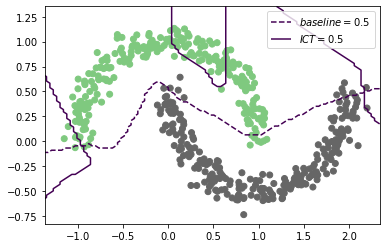

In [32]:
# Determine grid range
x0_min, x0_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
x1_min, x1_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1

# Create grid
x0, x1 = np.meshgrid(np.linspace(x0_min, x0_max, 100),
                     np.linspace(x1_min, x1_max, 100))
grid = torch.FloatTensor(np.hstack((x0.reshape(-1, 1), x1.reshape(-1, 1))))

# Plot the data
plt.scatter(*xval.T, c=yval, cmap=plt.cm.Accent)

# Evaluate baseline on the grid and plot decision boundary
bl_pred = (best_model2(grid.to(device)).squeeze() >= 0.5).cpu().numpy().reshape(x0.shape)
cs = plt.contour(x0, x1, bl_pred, levels=[0.5], linestyles='--')
h1, l1 = cs.legend_elements("baseline")

eaat_pred = (best_model(grid.to(device)).squeeze() >= 0.5).cpu().numpy().reshape(x0.shape)
cs = plt.contour(x0, x1, eaat_pred, levels=[0.5])
h2, l2 = cs.legend_elements("ICT")

plt.legend(h1 + h2, l1 + l2)